In [77]:
from functools import cached_property

import math
%load_ext autoreload
%autoreload 2

from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_scipy_sparse_matrix
from tqdm import tqdm

from gnn_tracking.graph_construction.radius_scanner import RadiusScanner
from gnn_tracking.training.ml import MLModule
from pathlib import Path
from torch_cluster import radius_graph
import pandas as pd
import torch
from gnn_tracking.utils.timing import Timer
from gnn_tracking.metrics.cluster_metrics import tracking_metric_df
import matplotlib.pyplot as plt
import numpy as np



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_exchange_path = Path(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/model_exchange"
)

In [3]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/"
        ],
        # If you run into memory issues, reduce this
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/"
        ],
        stop=5
    ),
)

In [4]:
dm.setup(stage="fit")

[15:14:53] INFO: DataLoader will load 900 graphs (out of 900 available).
[15:14:53] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21999_s0.pt
[15:14:53] INFO: DataLoader will load 5 graphs (out of 1000 available).
[15:14:53] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29004_s0.pt


In [5]:
model = MLModule.load_from_checkpoint(model_exchange_path / "gc" / "gc-7dce6aff.ckpt")

[15:14:53] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[15:14:54] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses


In [6]:
data = dm.datasets["train"][1]
out = model(data)
len(data.x)

64253

In [7]:
h = out["H"].detach()

In [8]:
out

{'H': tensor([[ 2.9730, -0.0253, -1.6322,  ...,  1.1640,  0.7052,  2.4498],
         [ 2.7304,  1.6124, -3.0960,  ...,  1.2405, -1.2601,  1.6289],
         [ 1.8941,  0.6949, -1.9455,  ...,  1.5763, -1.4844,  1.5647],
         ...,
         [ 2.1145,  0.1970, -2.7218,  ...,  0.4740, -0.2702,  2.6909],
         [ 1.5417,  0.0789, -2.1065,  ...,  0.4393, -0.3658,  2.9885],
         [ 2.3434,  0.0805, -2.7779,  ...,  0.4480, -0.1124,  2.4935]],
        grad_fn=<MulBackward0>)}

In [9]:
# rsc = RadiusScanner(model_output=[{"x": out["H"], "particle_id": data.particle_id, "reconstructable": data.reconstructable}], radius_range=(0.001, 1), n_trials=10)
# rsc()

In [10]:
from gnn_tracking.graph_construction.radius_scanner import construct_graph

t =Timer()
graph = construct_graph({"x": out["H"], "particle_id": data.particle_id, "reconstructable": data.reconstructable, "pt": data.pt}, radius=0.2)
t()

0.2683020969852805

In [11]:
len(graph.particle_id.unique())

9360

In [12]:

import scipy
from torch_geometric.data import Data
import networkx as nx

def get_largest_segment_fracs_scipy(data: Data, pt_thld=0.9, partitions=500, n_particles_sampled=None) -> np.ndarray:
    """A fast way to get the fraction of hits in the largest segment for each track.

    Args:
        data:
        pt_thld:
        partitions: This value only affects performance. It is the number of partitions
            to split the particle ids into. Setting this to ~500 can result in speedups
            of up to a factor of 15 (depending on number of edges).
        n_particles_sampled: If not None, only consider a subsample of the particles.
            This speeds up calculation.

    Returns:
        Array of fractions.
    """
    t = Timer()
    basic_hit_mask = (
        (data.pt > pt_thld) & (data.particle_id > 0) & (data.reconstructable > 0)
    )
    unique_pids = data.particle_id[basic_hit_mask].unique()
    if n_particles_sampled is not None:
        rand_perm = torch.randperm(len(unique_pids))
        unique_pids = unique_pids[rand_perm][:n_particles_sampled]
        basic_hit_mask &= torch.isin(data.particle_id, unique_pids)
    rdata = Data(
        edge_index=data.edge_index,
        particle_id=data.particle_id,
        num_nodes=len(data.particle_id),
    ).subgraph(basic_hit_mask)
    r = []
    # The edge masks are the most performance intensive part of this function.
    # Therefore, we first split pids in groups and calculate the edge masks for each
    # group, thereafter refining this selection.
    unique_pids_grouped = [
        unique_pids[i : i + partitions] for i in range(0, len(unique_pids), partitions)
    ]
    print(t())
    t_masking_0 = 0
    t_masking_1 = 0
    t_masking_2 = 0
    t_component = 0
    for pid_group in unique_pids_grouped:
        t = Timer()
        g_hit_mask = torch.isin(rdata.particle_id, pid_group)
        gdata = rdata.subgraph(g_hit_mask)
        t_masking_0 += t()
        for pid in pid_group:
            t = Timer()
            hit_mask: Tensor = gdata.particle_id == pid  # type: ignore
            hit_locations = hit_mask.nonzero().squeeze(dim=-1)
            t_masking_1 += t()
            n_hits = hit_mask.sum().item()
            assert n_hits > 0
            assert n_hits == len(hit_locations), (n_hits, len(hit_locations))
            t = Timer()
            edge_mask = (
                hit_mask[gdata.edge_index[0, :]] & hit_mask[gdata.edge_index[1, :]]
            )
            edge_index = gdata.edge_index[:, edge_mask]
            if edge_index.shape[1] == 0:
                r.append(0)
                continue
            # print("---")
            # print(edge_index.shape, n_hits)
            # print(edge_index)
            # print(len(np.unique(edge_index)))
            t_masking_2 += t()
            adj = to_scipy_sparse_matrix(edge_index)
            # print(edge_index)
            # print(adj)
            # break
            t()
            _, components = scipy.sparse.csgraph.connected_components(adj)
            _, count = np.unique(components, return_counts=True)
            r.append(max(count) / n_hits)
            t_component += t()
    # print(t_masking_0, t_masking_1, t_masking_2, t_masking_0 + t_masking_1 + t_masking_2, t_component)
    return np.array(r)

In [13]:
def get_largest_segment_fracs_nx(data: Data, pt_thld=0.9, partitions=500, n_particles_sampled=None) -> np.ndarray:
    """A fast way to get the fraction of hits in the largest segment for each track.

    Args:
        data:
        pt_thld:
        partitions: This value only affects performance. It is the number of partitions
            to split the particle ids into. Setting this to ~500 can result in speedups
            of up to a factor of 15 (depending on number of edges).
        n_particles_sampled: If not None, only consider a subsample of the particles.
            This speeds up calculation.

    Returns:
        Array of fractions.
    """
    t = Timer()
    basic_hit_mask = (
        (data.pt > pt_thld) & (data.particle_id > 0) & (data.reconstructable > 0)
    )
    unique_pids = data.particle_id[basic_hit_mask].unique()
    if n_particles_sampled is not None:
        rand_perm = torch.randperm(len(unique_pids))
        unique_pids = unique_pids[rand_perm][:n_particles_sampled]
        basic_hit_mask &= torch.isin(data.particle_id, unique_pids)
    rdata = Data(
        edge_index=data.edge_index,
        particle_id=data.particle_id,
        num_nodes=len(data.particle_id),
    ).subgraph(basic_hit_mask)
    r = []
    # The edge masks are the most performance intensive part of this function.
    # Therefore, we first split pids in groups and calculate the edge masks for each
    # group, thereafter refining this selection.
    unique_pids_grouped = [
        unique_pids[i : i + partitions] for i in range(0, len(unique_pids), partitions)
    ]
    t_masking_0 = 0
    t_masking_1 = 0
    t_masking_2 = 0
    t_masking_3 = 0
    t_component = 0
    for pid_group in unique_pids_grouped:
        t = Timer()
        g_hit_mask = torch.isin(rdata.particle_id, pid_group)
        gdata = rdata.subgraph(g_hit_mask)
        t_masking_0 += t()
        for pid in pid_group:
            t = Timer()
            hit_mask: Tensor = gdata.particle_id == pid  # type: ignore
            hit_locations = hit_mask.nonzero().squeeze(dim=-1)
            n_hits = hit_mask.sum().item()
            assert n_hits > 0
            assert n_hits == len(hit_locations), (n_hits, len(hit_locations))
            edge_mask = (
                hit_mask[gdata.edge_index[0, :]] & hit_mask[gdata.edge_index[1, :]]
            )
            t_masking_1 += t()
            edge_index = gdata.edge_index[:, edge_mask]
            t_masking_3 += t()
            segment_subgraph = nx.Graph()
            segment_subgraph.add_nodes_from(
                hit_locations.detach().cpu().numpy().tolist()
            )
            segment_subgraph.add_edges_from(
                edge_index.T.detach().cpu().numpy()
            )
            assert segment_subgraph.number_of_nodes() == n_hits, (
                segment_subgraph.number_of_nodes(),
                n_hits,
            )
            t()
            segments: list[Sequence[int]] = sorted(  # type: ignore
                nx.connected_components(segment_subgraph), key=len, reverse=True
            )
            r.append(len(segments[0]) / n_hits)
            t_component += t()
    t_masking = t_masking_0 + t_masking_1 + t_masking_2+ t_masking_3
    # print(t_masking_0, t_masking_1, t_masking_2, t_masking_3, t_masking, t_component, t_component+t_masking)
    return np.array(r)

In [14]:
graph.particle_id[graph.pt > 0.9]

tensor([567456645425135616, 864691884369379328, 851180879328837632,
         ...,  31526915378511872, 869200981554888704,
        324274085297127424])

In [15]:
tmp_mask = (graph.particle_id == 864691884369379328) | (graph.particle_id == 869200981554888704)
tdata = graph.subgraph(tmp_mask)

In [16]:
from collections import defaultdict
from typing import Sequence, Set


def get_largest_segment_fracs_nx2(data: Data, pt_thld=0.9, n_particles_sampled=None) -> np.ndarray:
    """A fast way to get the fraction of hits in the largest segment for each track.

    Args:
        data:
        pt_thld:
        n_particles_sampled: If not None, only consider a subsample of the particles.
            This speeds up calculation.

    Returns:
        Array of fractions.
    """
    basic_hit_mask = (
        (data.pt > pt_thld) & (data.particle_id > 0) & (data.reconstructable > 0)
    )
    unique_pids, counts = torch.unique(data.particle_id[basic_hit_mask], return_counts=True)
    pid2count = dict(zip(unique_pids.tolist(), counts.tolist()))
    if n_particles_sampled is not None:
        rand_perm = torch.randperm(len(unique_pids))
        unique_pids = unique_pids[rand_perm][:n_particles_sampled]
        basic_hit_mask &= torch.isin(data.particle_id, unique_pids)
    rdata = Data(
        edge_index=data.edge_index[:, data.y],
        particle_id=data.particle_id,
        num_nodes=len(data.particle_id),
    ).subgraph(basic_hit_mask)
    gx = nx.Graph()
    gx.add_edges_from(
        rdata.edge_index.T.detach().cpu().numpy()
    )
    segments: list[Set[int]] = nx.connected_components(gx)
    pid_to_largest_segment = defaultdict(int)
    for segment in segments:
        pid = rdata.particle_id[list(segment)[0]].item()
        pid_to_largest_segment[pid] = max(pid_to_largest_segment[pid], len(segment) / pid2count[pid])
    missing_pids = set(unique_pids.tolist()) - set(pid_to_largest_segment)
    for pid in missing_pids:
        pid_to_largest_segment[pid] = 1 / pid2count[pid]
    return np.array(list( pid_to_largest_segment.values()))

In [119]:
t()
get_largest_segment_fracs_nx2(graph)
t()

0.07376493397168815


0.07929447095375508

In [17]:
from torch_cluster import knn_graph


def knn_with_max_radius(x, k: int, max_radius: float | None = None) :
    """A version of kNN that excludes edges with a distance larger than a given radius.

    Args:
        x:
        k: Number of neighbors
        max_radius:

    Returns:
        edge index
    """
    edge_index = knn_graph(x, k=k)
    if max_radius is not None:
        dists = (x[edge_index[0]] - x[edge_index[1]]).norm(dim=-1)
        edge_index = edge_index[:, dists < max_radius]
    return edge_index

In [74]:
from gnn_tracking.utils.log import logger
from pytorch_lightning.core.mixins import HyperparametersMixin


class GraphConstructionKNNScanner(HyperparametersMixin):
    def __init__(self, ks: list[float], max_radius=1.0, pt_thld=0.9, subsample_pids: int|None =None, max_edges=5_000_000):
        super().__init__()
        self.save_hyperparameters()
        self._results = []

    @property
    def results(self) -> pd.DataFrame:
        return pd.DataFrame.from_records(self._results)

    @property
    def results_mean(self) -> pd.DataFrame:
        return self.results.groupby("k").mean()

    def reset(self):
        self._results = []

    def __call__(self, data, i_batch: int, progress=False):
        if i_batch == 0:
            self.reset()
        iterator = self.hparams.ks
        if progress:
            iterator = tqdm(iterator)
        for k in iterator:
            data.edge_index = knn_with_max_radius(data.x, k=k, max_radius=self.hparams.max_radius)
            n_edges =  data.edge_index.shape[1]
            if n_edges > self.hparams.max_edges:
                logger.warning("Not scanning k>=%d because max edges exceeded (%d > %d)", k, n_edges, self.hparams.max_edges)
                break
            data.y = data.particle_id[data.edge_index[0]] == data.particle_id[data.edge_index[1]]
            lsfs = get_largest_segment_fracs_nx2(data)
            self._results.append({
                "k": k,
                "frac50": (lsfs > 0.5).mean().item(),
                "frac75": (lsfs > 0.75).mean().item(),
                "frac100": (lsfs == 1).mean().item(),
                "n_edges": n_edges
            })

In [87]:
gc = GraphConstructionKNNScanner(ks=np.arange(0, 40, 4).tolist())
gc(graph, 0, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [92]:
ksr = KScanResults(gc.results_mean, targets=[0.5, 0.95])

<Axes: >

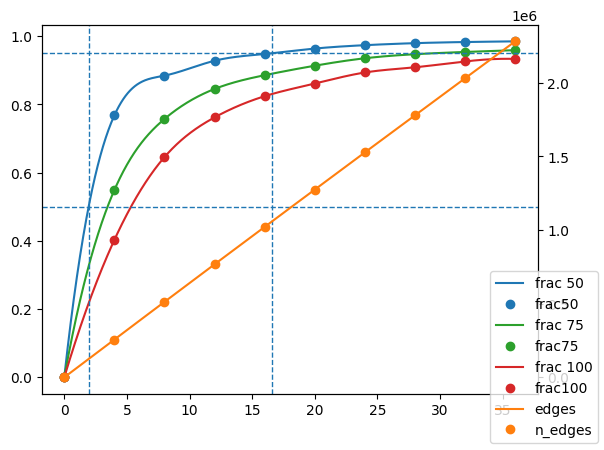

In [94]:
ksr.plot()

In [91]:

from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from gnn_tracking.utils.dictionaries import pivot_record_list


class KScanResults:
    def __init__(
        self,
        results: pd.DataFrame,
        targets: Sequence[float],
    ):
        """This object holds the results of scanning over ks. It performs
        interpolation to get the figures of merit (FOMs).

        Args:
            results: The results of the scan: (k, n_edges, frac50, ...)
            targets: The targets 50%-segment fractions that we're interested in
        """
        self.df = results.sort_values("k")
        self.df["k"] = self.df.index
        self.targets = targets

    def get_foms(self) -> dict[str, float]:
        foms = {}
        for t in self.targets:
            fat = self._get_foms_at_target(t)
            foms[f"n_edges_frac_segment50_{t*100:.0f}"] = fat["n_edges"]
            foms[f"n_edges_frac_segment50_{t*100:.0f}_k"] = fat["k"]
            foms[f"frac75_at_frac_segment50_{t*100:.0f}"] = fat["frac75"]
            foms[f"frac100_at_frac_segment50_{t*100:.0f}"] = fat["frac100"]
        idx_max_frac50 = self.df["frac50"].argmax()
        fat = self.df.iloc[idx_max_frac50]
        foms["max_frac_segment50"] = fat["frac50"]
        foms["n_edges_max_frac_segment50"] = fat["n_edges"]
        foms["max_frac_segment50_k"] = fat["k"]
        foms["frac75_at_max_frac_segment50"] = fat["frac75"]
        foms["frac100_at_max_frac_segment50"] = fat["frac100"]
        return foms

    def plot(self) -> plt.Axes:
        """Plot interpolation"""
        bounds = (
            self.df["k"].min(),
            self.df["k"].max(),
        )
        xs = np.linspace(*bounds, 1000)
        df = pd.DataFrame(pivot_record_list([self._eval_spline(x) for x in xs]))
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
        ax.plot("k", "frac50", data=df, marker="none", color="C0", label="frac 50")
        ax.plot("k", "frac50", data=self.df, marker="o", color="C0", ls="none")
        ax2.plot("k", "n_edges", data=df, marker="none", color="C1", label="edges")
        ax2.plot("k", "n_edges", data=self.df, marker="o", color="C1", ls="none")
        ax.plot("k", "frac75", data=df, marker="none", color="C2", label="frac 75")
        ax.plot("k", "frac75", data=self.df, marker="o", color="C2", ls="none")
        ax.plot(
            "k", "frac100", data=df, marker="none", color="C3", label="frac 100"
        )
        ax.plot("k", "frac100", data=self.df, marker="o", color="C3", ls="none")
        for t in self.targets:
            ax.axhline(t, linestyle="--", lw=1, color="C0")
        for target in self.targets:
            ax.axvline(
                self._get_target_k(target), linestyle="--", lw=1, color="C0"
            )
        fig.legend(loc="lower right")
        return ax

    @cached_property
    def _spline(self):
        return CubicSpline(self.df["k"], self.df)

    def _eval_spline(self, k: float) -> dict[str, float]:
        # Unclear why sometimes the spline returns a 2D array
        _r = self._spline(k).squeeze().tolist()
        return dict(zip(self.df.columns, _r))

    def _get_target_k(self, target: float) -> float:
        """K at which the 50%-segment fraction = target"""
        if target > self.df["frac50"].max():
            return float("nan")
        bounds = (
            self.df["k"].min().item(),
            self.df["k"].max().item(),
        )
        initial_value = sum(bounds) / 2
        return minimize(
            lambda k: np.abs(self._eval_spline(k)["frac50"] - target),
            x0=initial_value,
            bounds=(bounds,),
        ).x.item()

    def _get_foms_at_target(self, target: float) -> dict[str, float]:
        _nan_results = {k: float("nan") for k in self.df.columns}
        if len(self.df) < 2:
            return _nan_results
        target_r = self._get_target_k(target)
        if math.isnan(target_r):
            return _nan_results
        return self._eval_spline(target_r)


In [73]:
gc.results_mean

,frac50,frac75,frac100,n_edges
k,,,,
0,0.000000,0.000000,0.000000,0.0
2,0.539021,0.273148,0.163360,128434.0
4,0.767857,0.548942,0.402778,256711.0
6,0.842593,0.673942,0.535053,384811.0
8,0.884259,0.757275,0.645503,512672.0
10,0.910053,0.810185,0.717593,640307.0
12,0.927910,0.845238,0.761905,767731.0
14,0.938492,0.869048,0.800265,894924.0
16,0.947751,0.885582,0.824074,1021890.0


In [67]:
gc.results_mean

,frac50,frac75,frac100,n_edges
k,,,,
0,0.000000,0.000000,0.000000,0.0
2,0.840608,0.640212,0.541005,20568.0
4,0.954365,0.886243,0.813492,41121.0
6,0.977513,0.937831,0.894180,61511.0
8,0.982804,0.954365,0.929233,81664.0
10,0.989418,0.967593,0.947751,101422.0
12,0.992725,0.978175,0.963624,120478.0
14,0.994048,0.982143,0.969577,138827.0
16,0.995370,0.984788,0.974206,156189.0


In [46]:
pd.DataFrame({"a": [1]}).groupby("a").mean()

""
a
1


In [68]:
class KNNMaxRadiusFastRescan:
    def __init__(self, x, k: int, max_radius = 1.):
        self._max_radius = max_radius
        self._edge_index = knn_graph(x, k=k)
        self._dists = (x[self._edge_index[0]] - x[self._edge_index[1]]).norm(dim=-1)
        self._filter_edge_index(r=max_radius)

    def _filter_edge_index(self, r):
        assert r <= self._max_radius
        if np.isclose(r, self._max_radius):
            return
        mask = self._dists < r
        self._edge_index = self._edge_index[:, mask]
        self._dists = self._dists[mask]
        self._max_radius = r

    def scan(self, r):
        self._filter_edge_index(r)
        return self._edge_index

In [69]:
import copy

results = []
nss = []
ks = list(range(1, 31))
epss = np.linspace(0.01, 1, 10)[::-1]
_data = copy.deepcopy(data)
t()
for k in ks:
    scanner = KNNMaxRadiusFastRescan(graph.x, k=k, max_radius=1)
    for eps in tqdm(epss):
        _data.edge_index = scanner.scan(eps)
        _data.y = _data.particle_id[_data.edge_index[0]] == _data.particle_id[_data.edge_index[1]]
        _r = get_largest_segment_fracs_nx2(_data, n_particles_sampled=None)
        r = {
            "eps": eps,
            "k": k,
            "dm": (_r > 0.5).sum() / len(_r),
            "n": _data.edge_index.shape[1],
        }
        results.append(r)
t()
rdf = pd.DataFrame.from_records(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.89it/s]


/tmp/ipykernel_1797076/301819916.py:2: RuntimeWarning: Second argument 'dm' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("n", "dm", label=k, data=rdf[rdf.k == k])


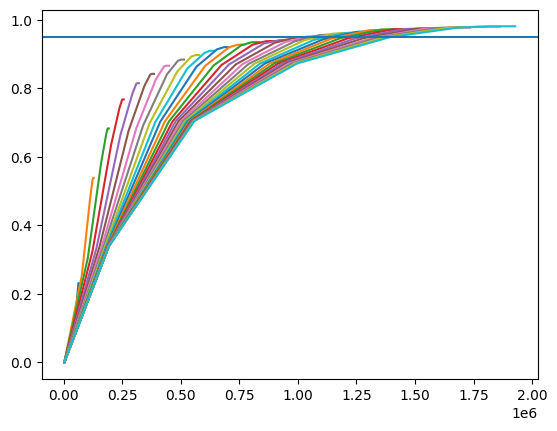

In [70]:
for k in rdf.k.unique():
    plt.plot("n", "dm", label=k, data=rdf[rdf.k == k])
plt.axhline(0.95)
# plt.legend()

In [70]:
# def get_latent_space_part(data, frac=0.5):
#     projected = data.x.sum(axis=1)
#     boundary = torch.quantile(projected, frac)
#     mask = projected < boundary
#     return data.subgraph(mask)